# Data analysis and Forecast of stock trading 
## By Hector Manuel Ramirez Contreras
### Using XGBoost and FinBERT
Datasets: stock_prices (price.csv), financial_news (news.csv)

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np 
from datetime import datetime

In [2]:
# Import datasets 
price_df = pd.read_csv("../data/price.csv")
news_df = pd.read_csv("../data/news.csv")

# Data wrangling and exploration

### Historical Price Data 
This dataset contains historical price and volume data for various trading tickers. For each ticker, the following information is provided:

- **date**: Trading date.
- **ticker**: Stock ticker symbol.
- **open**: Opening price of the stock on the given date.
- **high**: Highest price reached by the stock during the trading day.
- **low**: Lowest price reached by the stock during the trading day.   
- **close**: Closing price of the stock at the end of the trading day.
- **volume**: Total number of shares traded on the given date.

In [3]:
#Getting to know the data using pandas
price_df.head()

,date,ticker,open,high,low,close,volume
0,2023-11-13,AAPL,185.820007,186.029999,184.210007,184.800003,43627500
1,2023-11-14,AAPL,187.699997,188.110001,186.300003,187.440002,60108400
2,2023-11-15,AAPL,187.850006,189.500000,187.779999,188.009995,53790500
3,2023-11-16,AAPL,189.570007,190.960007,188.649994,189.710007,54412900
4,2023-11-17,AAPL,190.250000,190.380005,188.570007,189.690002,50922700


In [4]:
price_df.info()
# In this dataset there are no missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1687 non-null   object 
 1   ticker  1687 non-null   object 
 2   open    1687 non-null   float64
 3   high    1687 non-null   float64
 4   low     1687 non-null   float64
 5   close   1687 non-null   float64
 6   volume  1687 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 92.4+ KB


In [5]:
price_df.describe()
# this does not say much in general because it only provides summary statistics and there are many tickers

,open,high,low,close,volume
count,1687.000000,1687.000000,1687.000000,1687.000000,1.687000e+03
mean,245.203879,248.029241,242.278194,245.264770,9.613876e+07
std,134.583166,135.776406,133.247946,134.540129,1.442287e+08
min,45.466000,46.077000,45.009998,45.502998,5.467500e+06
25%,158.190002,160.525002,156.540001,159.059998,2.076580e+07
50%,187.360001,189.279999,185.419998,187.429993,3.934310e+07
75%,371.489990,374.440002,368.845001,372.860001,8.306055e+07
max,598.219971,602.950012,589.960022,595.940002,1.142269e+09


In [6]:
news_df.head()

,datetime,ticker,headline,summary
0,2024-10-29 18:07:48,AAPL,Apple Unveils the Redesigned Mac Mini,-- Apple overhauled the design of its Mac mini...
1,2024-10-29 02:21:10,AAPL,Apple blocked from selling iPhone 16 in Indone...,TECH giant Apple will not be allowed to sell i...
2,2024-10-28 14:05:22,AAPL,"Apple Rises on Apple Intelligence Rollout, New...",-- Apple unveiled its new iMac and said Apple ...
3,2024-10-28 12:05:04,AAPL,Apple : How Apple developed the world’s first ...,apple stories Inside the Audio Lab: How Apple ...
4,2024-10-28 11:02:06,AAPL,Apple launches the iPhone into the AI era with...,Apple is releasing a free software update that...


In [7]:
news_df.info()
# Here I can see there is a missing value that is worth investigating.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4440 entries, 0 to 4439
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  4440 non-null   object
 1   ticker    4440 non-null   object
 2   headline  4440 non-null   object
 3   summary   4439 non-null   object
dtypes: object(4)
memory usage: 138.9+ KB


In [8]:
# I will check which entry has the missing data
news_df["datetime"] = pd.to_datetime(news_df["datetime"])
news_df[news_df.isna().any(axis=1)]
#  this entry has missing data, it does not have a corresponding news article, just a headline, however sometimes the headline can be misleading

,datetime,ticker,headline,summary
1255,2024-10-09 06:10:11,AMZN,Sellers Prepare Legal Action Against Amazon Cl...,NaN


In [9]:
rand_int = np.random.randint(0, 100)
print(news_df['summary'][rand_int])

-- Apple shares slumped as analyst warned of weaker iPhone 16 demand. But Bloomberg Intelligence's Anurag Rana says it is too early to call it anemic demand for this new product, and he anticipates a...


In [10]:
# I will handle the missing value, first I will see id there are other news in that day that can be used

missing_val = news_df[news_df.isna().any(axis=1)].datetime
news_df[(news_df.datetime.dt.date == missing_val.dt.date.iloc[0])& (news_df.ticker == "AMZN")]


,datetime,ticker,headline,summary
1240,2024-10-09 23:31:06,AMZN,Amazon com : Apple TV+ launching on Prime Vide...,Primein the U.S. will soon be able to subscrib...
1241,2024-10-09 16:48:06,AMZN,"Amazon com : announces AI Shopping Guides, gen...","SEATTLE-October 9, 2024-Amazon today announced..."
1242,2024-10-09 15:14:09,AMZN,Amazon com : announces 7 new innovations that ...,Amazon unveiled major announcements in deliver...
1243,2024-10-09 15:14:05,AMZN,Amazon com : Meet the 8 robots powering your A...,Amazon's foray into roboticsbegan more than a ...
1244,2024-10-09 14:28:04,AMZN,"Amazon com : How Amazon is helping employees, ...",Amazon deploys relief supplies and advanced te...
1245,2024-10-09 12:26:06,AMZN,Exclusive look: 16 photos from inside the Amaz...,"Get a rare peek inside Lab126 in Sunnyvale, Ca..."
1246,2024-10-09 11:28:11,AMZN,Amazon com : Climate Pledge Fund adds investme...,We've also incorporated five CPF companies int...
1247,2024-10-09 11:16:06,AMZN,Amazon com : Pharmacy plans to expand Same-Day...,Amazon Pharmacy is accelerating its rollout of...
1248,2024-10-09 11:14:07,AMZN,Amazon com : 3 new ways Amazon is offering mor...,We're bringing together the best of Whole Food...
1249,2024-10-09 11:06:05,AMZN,Amazon com : How Amazon is improving packaging...,"Across the globe, we continue to find ways to ..."


In [11]:
# The date and the ticker have enough information to get a sentiment from the news articles, there is no need to impute the missing values
news_df.dropna(inplace=True)
news_df.isna().sum()

datetime    0
ticker      0
headline    0
summary     0
dtype: int64

### Historical News
This dataset provides real-time news articles related to specific trading tickers. Each news article includes:

- **datetime**: Timestamp of the news article's publication.
- **ticker**: Stock ticker symbol associated with the news.
- **headline**: Concise summary of the news article.
- **summary**: Summarization of the article content.

## Exploratory Data Analysis (EDA)

Some early observations of the data
- The datasets can be joined by ticker, most likely also by date, however there is difference between timestamps.  
- The news can provide context and additional information about price movements.

In [12]:
print(f"Number of dtapoints in price dataframe: {price_df.shape[0]}")
print(f"Number of dtapoints in news  dataframe: {news_df.shape[0]}")

Number of dtapoints in price dataframe: 1687
Number of dtapoints in news  dataframe: 4439


There is a clear difference between the number of datapoints between datasets. The price dataframe contins the historical price per ticker each day, whereas the news dataframe can have different news from different sources at a given hour.

In [13]:
print(f"The tickers in the stock document are: {price_df.ticker.unique()}, category count: {price_df.ticker.unique().shape[0]}")

print(f"The tickers in the news document are: {news_df.ticker.unique()},  category count: {price_df.ticker.unique().shape[0]}")

The tickers in the stock document are: ['AAPL' 'GOOGL' 'AMZN' 'TSLA' 'META' 'NVDA' 'MSFT'], category count: 7
The tickers in the news document are: ['AAPL' 'GOOGL' 'AMZN' 'TSLA' 'META' 'NVDA' 'MSFT'],  category count: 7


There are 7 categories or companies that are in the document, these are major companies such as:
- APPL: Apple Inc.
- MSFT: Microsoft Corporation
- AMZN: Amazon.com Inc.
- GOOGL: Alphabet Inc.
- TSLA: Tesla Inc.
- META: Meta Platforms Inc.
- NVDA: NVIDIA Corporation

These companies are present in both documents, however I will check if both datastes have similar logs for these companies and if the datasets are balanced.

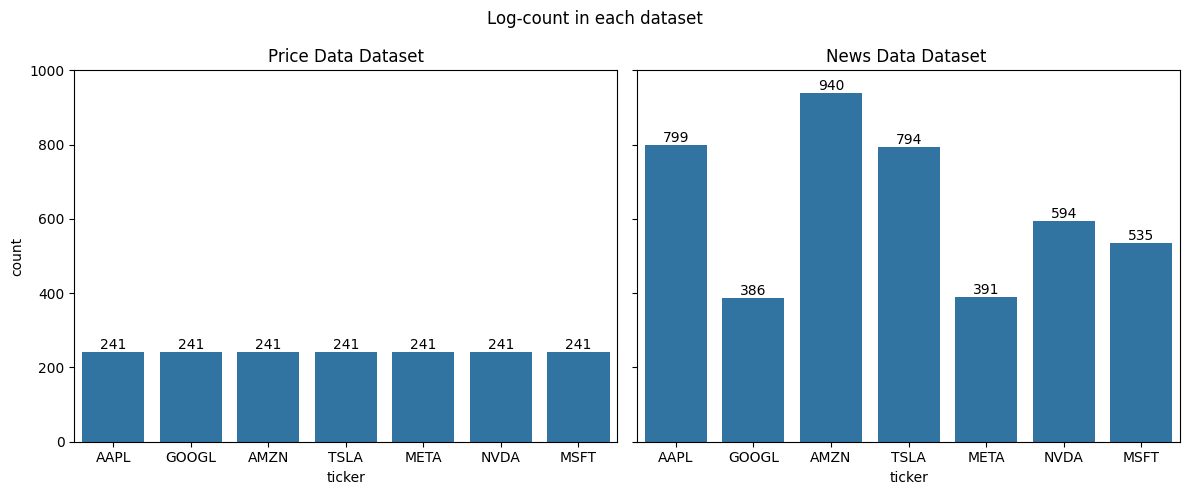

In [14]:
# Checking how many data points are available for each ticker and dataset 

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey= True)

plt.ylim(0,1000)
sns.countplot(data=price_df, x="ticker", ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].set_title("Price Data Dataset")

sns.countplot(data=news_df, x="ticker", ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].set_title("News Data Dataset ")
fig.suptitle("Log-count in each dataset")

plt.tight_layout()
plt.show()

In [15]:
# The data difference can be because the news data is more granular, with multiple entries per day. I will check the how many unique dates there are. 
news_df["datetime"] = pd.to_datetime(news_df.datetime)
news_df["date"] = news_df["datetime"].dt.date
news_df

,datetime,ticker,headline,summary,date
0,2024-10-29 18:07:48,AAPL,Apple Unveils the Redesigned Mac Mini,-- Apple overhauled the design of its Mac mini...,2024-10-29
1,2024-10-29 02:21:10,AAPL,Apple blocked from selling iPhone 16 in Indone...,TECH giant Apple will not be allowed to sell i...,2024-10-29
2,2024-10-28 14:05:22,AAPL,"Apple Rises on Apple Intelligence Rollout, New...",-- Apple unveiled its new iMac and said Apple ...,2024-10-28
3,2024-10-28 12:05:04,AAPL,Apple : How Apple developed the world’s first ...,apple stories Inside the Audio Lab: How Apple ...,2024-10-28
4,2024-10-28 11:02:06,AAPL,Apple launches the iPhone into the AI era with...,Apple is releasing a free software update that...,2024-10-28
...,...,...,...,...,...
4435,2023-11-16 13:09:17,MSFT,OpenAI explores how to get ChatGPT into classr...,"OpenAI, whosegenerative AI products initially ...",2023-11-16
4436,2023-11-16 10:56:03,MSFT,Microsoft : at the top thanks to the Ignite co...,"On Thursday, Microsoft posted one of the stron...",2023-11-16
4437,2023-11-16 10:13:02,MSFT,Microsoft : Wedbush again raises its price target,Wedbush Securities on Thursday raised its pric...,2023-11-16
4438,2023-11-14 22:05:03,MSFT,Microsoft Announces Expiration and Final Resul...,"REDMOND, Wash., Nov. 14, 2023 /PRNewswire/ -- ...",2023-11-14


In [16]:
print("---- Unique Dates ----")
print("Number of unique dates in price data:", price_df.date.unique().shape[0])
print("Number of unique dates in news data:", news_df.date.unique().shape[0])
print("---- Date Range ----")
print("oldest and newest dates in price data:", price_df.date.min(), "to", price_df.date.max())
print("oldest and newest dates in news data:", news_df.date.min(), "to", news_df.date.max())

---- Unique Dates ----
Number of unique dates in price data: 241
Number of unique dates in news data: 311
---- Date Range ----
oldest and newest dates in price data: 2023-11-13 to 2024-10-28
oldest and newest dates in news data: 2023-11-13 to 2024-10-29


In [17]:
# I will merge the pairs tickers/date to understand how many datapoints will be affected for the differnece between news and price data
news_ticker_date = news_df.groupby(["ticker", "date"]).size().reset_index(name='count').sort_values(by="date", ascending=False)
price_ticker_date = price_df.groupby(["ticker", "date"]).size().reset_index(name='count').sort_values(by="date", ascending=False)
date_compare = pd.merge(news_ticker_date, price_ticker_date, on=["ticker", "date"], suffixes=("_news", "_price"), how="outer")
date_compare.groupby(["ticker", "date"])

In [18]:
date_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       3074 non-null   object 
 1   date         3074 non-null   object 
 2   count_news   1387 non-null   float64
 3   count_price  1687 non-null   float64
dtypes: float64(2), object(2)
memory usage: 96.2+ KB


### Data visualization

C:\Users\hecma\AppData\Local\Temp\ipykernel_13272\1948129213.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


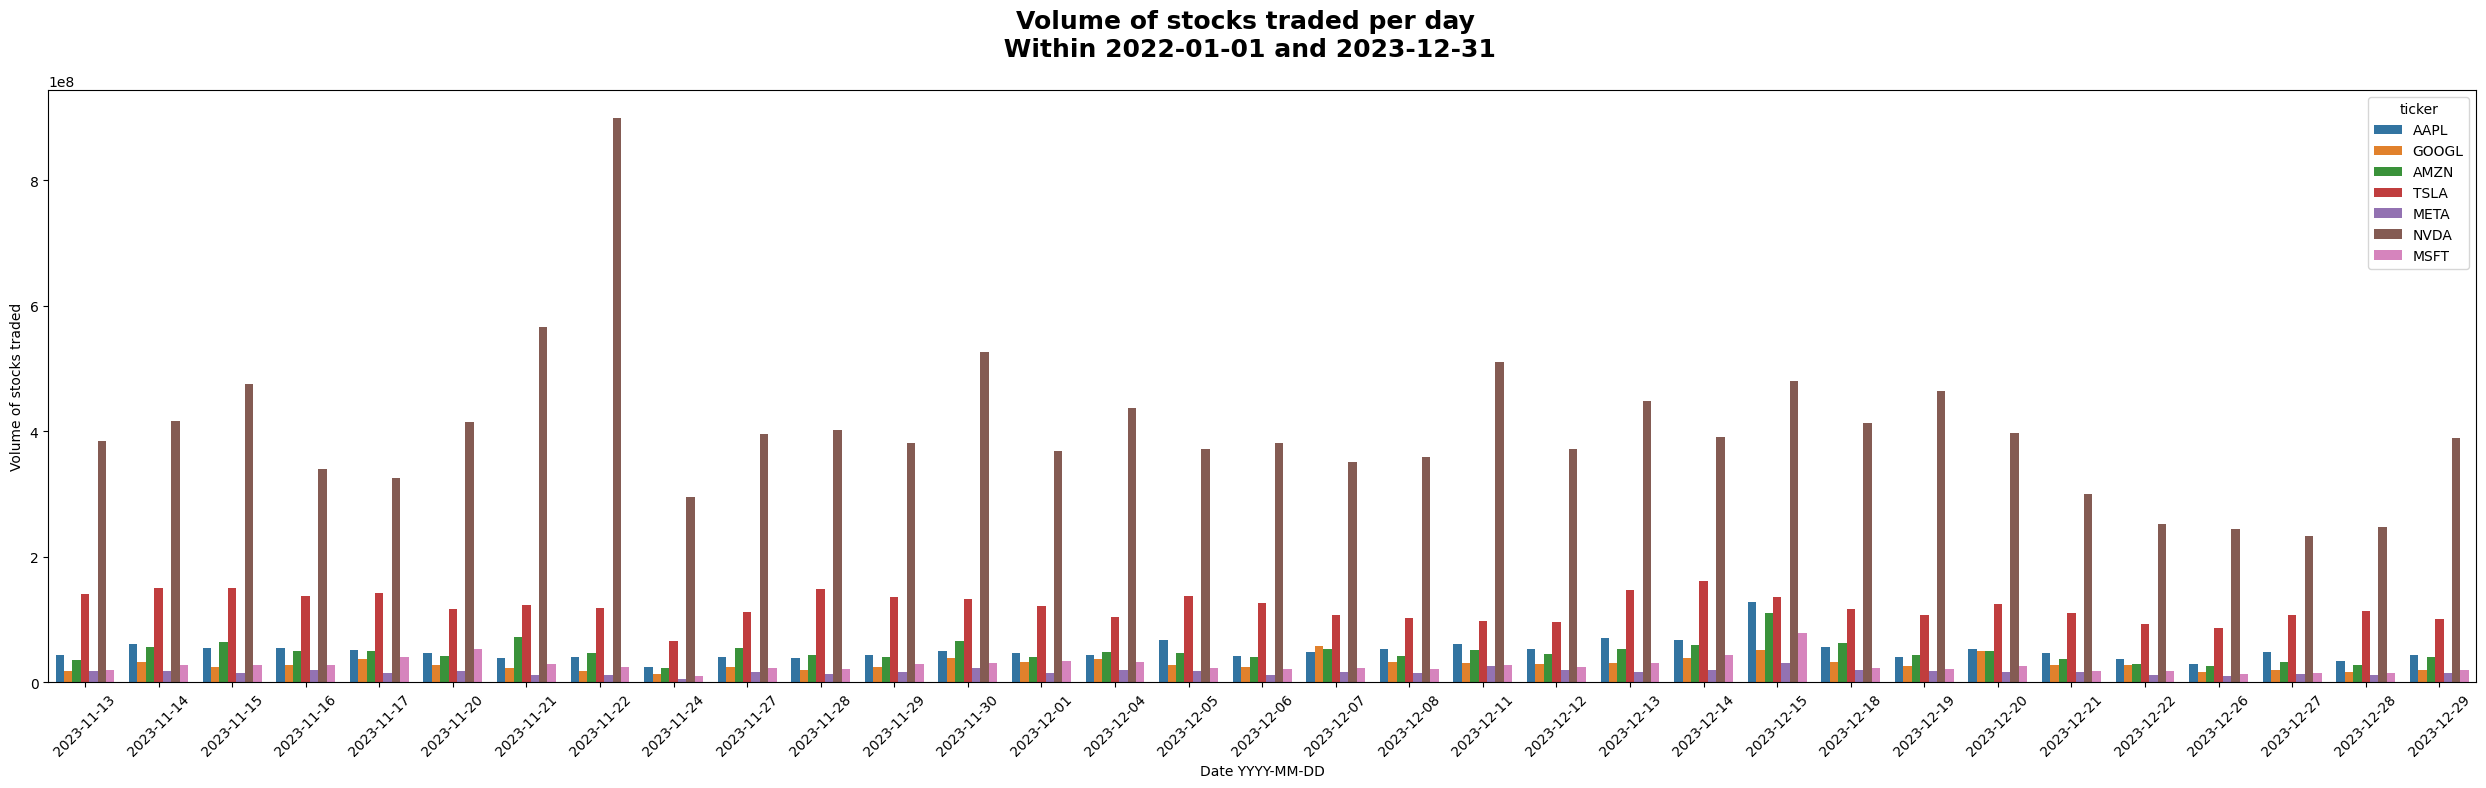

In [19]:
start_date = "2022-01-01"
end_date = "2023-12-31"

fig, ax = plt.subplots(figsize=(25, 8))
sns.barplot(data=price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)], x="date", y="volume", dodge=True, hue="ticker")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.suptitle(f"Volume of stocks traded per day\n Within {start_date} and {end_date}", fontsize=18, fontweight='bold')
ax.yaxis.set_label_text("Volume of stocks traded")
ax.xaxis.set_label_text("Date YYYY-MM-DD")
fig.tight_layout()
plt.show()

In this case there are not many tickers to compare, so the visualization is straightforward. However, I decided to set a date range to better visualize the Highest Average Trading Volume within the selected period.

In [20]:
## this is just an example to see how the candlestick chart looks, however it is possible to manually select the tickers 
import plotly.graph_objects as go
from ipywidgets import widgets

df = price_df.copy()
price_df = price_df.copy()

tickers = df['ticker'].unique()
s = 0  # Index of the ticker to visualize
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df[df['ticker'] == tickers[s]]['open'],
                high=df[df['ticker'] == tickers[s]]['high'],
                low=df[df['ticker'] == tickers[s]]['low'],
                close=df[df['ticker'] == tickers[s]]['close'])])
fig.update_layout(title=f'Candlestick chart for {tickers[s]}', xaxis_title='Date', yaxis_title='Price')
fig.show()


To avoid having one plot for all tickers, I will create separate plots for each ticker's rolling features, but using plotly for better interactivity. and visualization.


In [21]:
import plotly.graph_objects as go


fig = go.Figure()

# Add a candlestick trace for each ticker, this is to create each ticker's candlestick chart
for t in tickers: 
    sub = df[df['ticker'] == t]
    fig.add_trace(
        go.Candlestick(
            x=sub['date'], open=sub['open'], high=sub['high'], low=sub['low'], close=sub['close'],
            name=t,
            visible=False  # we'll activate one of them with the dropdown
        )
    )

# Make the first ticker visible by default
fig.data[0].visible = True

# Create dropdown buttons
dropdown_buttons = []
for i, t in enumerate(tickers):
    # Create a mask where only the i-th trace is visible
    visibility = ['legendonly'] * len(tickers)
    visibility[i] = True

    dropdown_buttons.append(
        dict(
            label=t,
            method="update",
            args=[{'visible': visibility},
                  {'title': f"{t} Stock Price"}]
        )
    )

# Add dropdown to layout
fig.update_layout(title="Stock Price for:",
                  updatemenus=[dict(active=0, buttons=dropdown_buttons, x=.08, y=1.2)]
                  )

fig.show()


Some important features of the data are 
- Close: The closing price of the stock on a given date, the variable I want to predict 
- Open: The opening price of the stock on a given date
- High: The highest price of the stock on a given date
- Low: The lowest price of the stock on a given date
- Volume: The number of shares traded on a given date

And some new features I will engineer in the next session to have better explainability: 
- Moving averages (e.g., 7-day, 30-day) to capture trends, however I will first check for stationarity [1]
- Stock price’s standard deviation for the past seven days (7 DAYS STD DEV)[1]
- Stock High minus Low price (H-L) [1]
- Stock Close minus Open price (O-C)

[1] https://linkinghub.elsevier.com/retrieve/pii/S1877050920307924

### Feature engineering

In [22]:
price_df

,date,ticker,open,high,low,close,volume
0,2023-11-13,AAPL,185.820007,186.029999,184.210007,184.800003,43627500
1,2023-11-14,AAPL,187.699997,188.110001,186.300003,187.440002,60108400
2,2023-11-15,AAPL,187.850006,189.500000,187.779999,188.009995,53790500
3,2023-11-16,AAPL,189.570007,190.960007,188.649994,189.710007,54412900
4,2023-11-17,AAPL,190.250000,190.380005,188.570007,189.690002,50922700
...,...,...,...,...,...,...,...
1682,2024-10-22,MSFT,418.489990,430.579987,418.040009,427.510010,25482200
1683,2024-10-23,MSFT,430.859985,431.079987,422.529999,424.600006,19654400
1684,2024-10-24,MSFT,425.329987,425.980011,422.399994,424.730011,13581600
1685,2024-10-25,MSFT,426.760010,432.519989,426.570007,428.149994,16899100


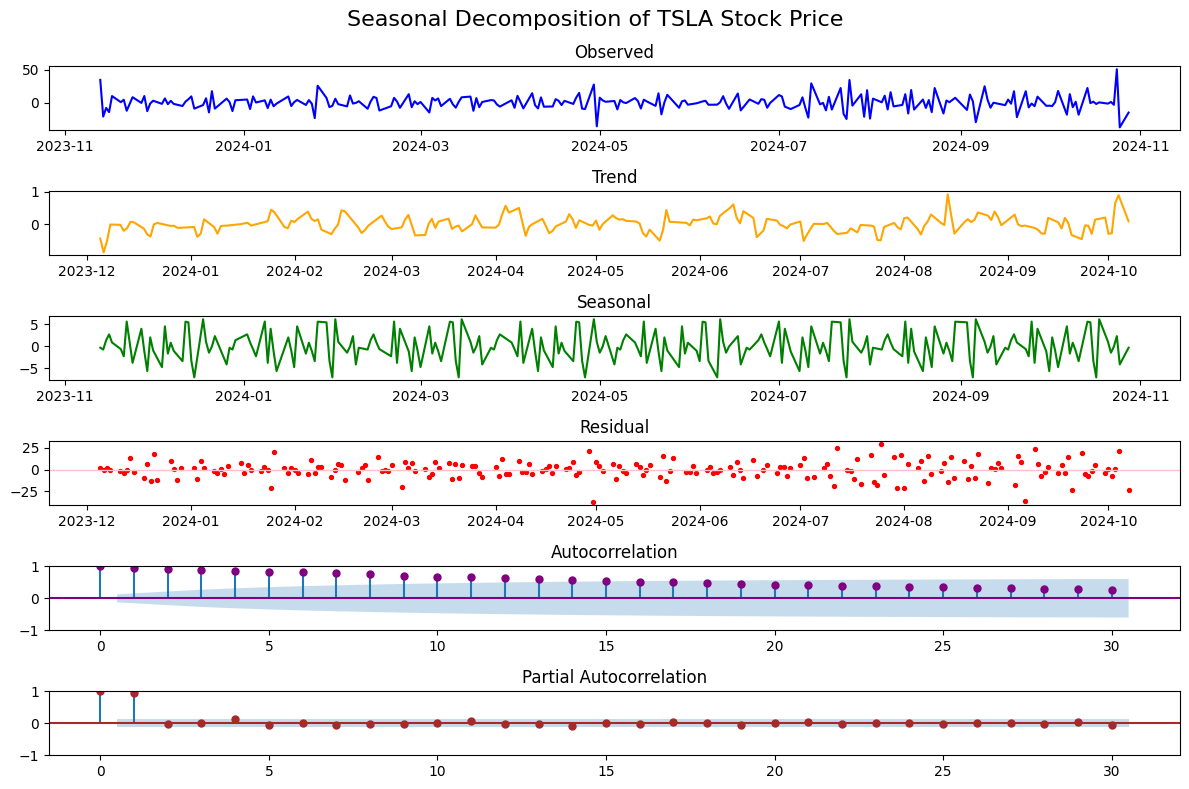

In [23]:
# I first will check for stationarity, seasonality and trends in the data
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels.api as sm
# ticker index to choose 
tk =3

# window size for rolling features
window = 30
#### Data Preparation
df_close = price_df[['date','ticker','close']].copy()
df_close['diff'] = df_close['close'].diff()
df_close['2_diff'] = df_close['diff'].diff()
df_close.dropna(inplace=True)
df_close= df_close[df_close['ticker'] == tickers[tk]]  # Example ticker, can be changed
df_close['date'] = pd.to_datetime(df_close['date'])
df_close.set_index('date', inplace=True)

# Plot rolling features 
fig, axs = plt.subplots(6, 1, figsize=(12, 5))
decompose = seasonal_decompose(df_close['2_diff'], model='additive', period=window) # also the period of the MA 

axs[0].plot(decompose.observed, color='blue')
axs[0].set_title('Observed')

axs[1].plot(decompose.trend, color='orange')
axs[1].set_title('Trend')

axs[2].plot(decompose.seasonal, color='green')
axs[2].set_title('Seasonal')

axs[3].scatter(decompose.resid.index, decompose.resid, color='red', s=8)
axs[3].axhline(0, color='pink', lw=1)
axs[3].set_title('Residual')
# ACF and PACF plots to determine stationarity and the number of lags to include
sm.graphics.tsa.plot_acf(df_close['close'], lags=window, ax=axs[4], color='purple')
sm.graphics.tsa.plot_pacf(df_close['close'], lags=window, ax=axs[5], color='brown')
fig.suptitle(f"Seasonal Decomposition of {tickers[tk]} Stock Price", fontsize=16)

fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

"A longer moving average, such as a 200-day EMA, can serve as a valuable smoothing device when you are trying to assess long-term trends. A shorter moving average, such as a 50-day moving average, will more closely follow the recent price action and therefore is frequently used to assess short-term patterns. Shorter-term moving averages are frequently referred to as "fast" because they change direction on the chart more quickly than a longer moving average. Alternatively, longer-term moving averages can be referred to as "slow.""[2]

However, the dataset has 241 logs per ticker, which may limit the effectiveness of very long moving averages. Therefore, I will primarily focus on shorter moving averages (e.g., 30-day, 7-day) for this analysis.
By inspecting the ACF and PACF plots, I can determine the appropriate lag values to include in the model. In this case, after the lag 20, the autocorrelation becomes much less significant. Moreover the PACF shows that the significant lags are primarily within the first 2 lags.

[2] https://www.fidelity.com/viewpoints/active-investor/moving-averages

In [24]:
# Example of computing the rolling mean, standard deviation, High - Low and Close - Open
def compute_features(df,ticker,long,short, lags, derivates):
    """Computes rolling features for the given ticker and creates a new dataset \n
    - df: The input dataframe containing stock price data
    - ticker: The stock ticker symbol
    - long: The window size for the long-term rolling features
    - short: The window size for the short-term rolling features

    Output: A dataframe with the computed rolling features, target values, and lagged features
    -- Features that returns 
    In this new subset I have new features engineered from the original dataset:
    - rolling mean for a month trend
    - rolling mean for a week trend
    - rolling standard deviation for a month trend
    - High - Low Difference:  that captures the volatility of the stock
    - Close - Open Difference:  that captures the gap between the opening and closing prices and return of investment per day
    - lag_1: the previous closing price, which can be useful for time series forecasting
    - target_close:  the future closing price that we want to predict at time t+1
    """
    df = df[df['ticker'] == ticker].copy()
    # rolling mean for a month trend 
    df['rolling_mean_long'] = df['close'].rolling(window=long).mean()
    #rolling mean for a week trend
    df['rolling_mean_short'] = df['close'].rolling(window=short).mean()
    # rolling standard deviation for a month trend
    df['rolling_std'] = df['close'].rolling(window=long).std()
    df['high_low_diff'] = df['high'] - df['low']
    df['close_open_diff'] = df['close'] - df['open']
    # My target value can't be included in my features, therefore I create it separately from a time shift
    for lag in lags:
        df[f'lag_{lag}'] = df['close'].shift(lag)
    for diff in derivates:
        df[f'{diff}_diff'] = df['close'].diff(diff)
    
    df['target_close'] = df['close'].shift(-1)
    
    return df

def plot_rolling_features(df, size, ticker):
    """Plots the rolling features for the given dataframe. it also plots autocorrelation plot and pacf 
    - df: The input dataframe containing rolling features 
    - size: The size of the plot
    - ticker: The ticker symbol
    """
    fig, axs = plt.subplots(2,1,figsize=size)
    df['date'] = pd.to_datetime(df['date'])
    # Plotting the rolling means and close price
    sns.lineplot(data=df, x='date', y='rolling_mean_long', label='30-day Rolling Mean', ax=axs[0])
    sns.lineplot(data=df, x='date', y='rolling_mean_short', label='7-day Rolling Mean', ax=axs[0])
    sns.lineplot(data=df, x='date', y='close', label='Close price', ax=axs[0])
    # Plotting the rolling standard deviation and engineered features
    sns.lineplot(data=df, x='date', y='rolling_std', label='30-day Rolling Std', ax=axs[1], color='purple')
    sns.lineplot(data=df, x='date', y='high_low_diff', label='High - Low Diff', ax=axs[1], color='red')
    sns.lineplot(data=df, x='date', y='close_open_diff', label='Close - Open Diff', ax=axs[1], color='black')
    axs[0].get_legend().set_visible(False)  # Hide legend for the first plot
    axs[1].get_legend().set_visible(False)  # Show legend for the second plot
    
    # Only show a tick every month and format as YYYY-MM
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    
    fig.autofmt_xdate()
    fig.suptitle(f"Rolling Features for {ticker} Stock Price", fontsize=16)
    fig.legend(loc='right', fontsize=12, bbox_to_anchor=(1.25, 0.5))
    fig.tight_layout() 
    plt.show()

    


In [25]:
test_ticker =tk
lags = [1,2]
derivates = [1,2]

test_df = compute_features(price_df, tickers[test_ticker], 30, 7, lags, derivates)

test_df

,date,ticker,open,high,low,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close
723,2023-11-13,TSLA,215.600006,225.399994,211.610001,223.710007,140447600,NaN,NaN,NaN,13.789993,8.110001,NaN,NaN,NaN,NaN,237.410004
724,2023-11-14,TSLA,235.029999,238.139999,230.720001,237.410004,149771600,NaN,NaN,NaN,7.419998,2.380005,223.710007,NaN,13.699997,NaN,242.839996
725,2023-11-15,TSLA,239.289993,246.699997,236.449997,242.839996,150354000,NaN,NaN,NaN,10.250000,3.550003,237.410004,223.710007,5.429993,19.129990,233.589996
726,2023-11-16,TSLA,239.490005,240.880005,230.960007,233.589996,136816800,NaN,NaN,NaN,9.919998,-5.900009,242.839996,237.410004,-9.250000,-3.820007,234.300003
727,2023-11-17,TSLA,232.000000,237.389999,226.539993,234.300003,142532800,NaN,NaN,NaN,10.850006,2.300003,233.589996,242.839996,0.710007,-8.539993,235.600006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,2024-10-22,TSLA,217.309998,218.220001,215.259995,217.970001,43268700,236.968333,219.781431,14.556137,2.960007,0.660004,218.850006,220.699997,-0.880005,-2.729996,213.649994
960,2024-10-23,TSLA,217.130005,218.720001,212.110001,213.649994,80938900,236.485666,218.994287,15.089608,6.610001,-3.480011,217.970001,218.850006,-4.320007,-5.200012,260.480011
961,2024-10-24,TSLA,244.679993,262.119995,242.649994,260.480011,204491900,237.508000,224.838573,15.650274,19.470001,15.800018,213.649994,217.970001,46.830017,42.510010,269.190002
962,2024-10-25,TSLA,256.010010,269.489990,255.320007,269.190002,161611900,238.804667,231.675716,16.613466,14.169983,13.179993,260.480011,213.649994,8.709991,55.540009,262.510010


In this new subset I have new features engineered from the original dataset:
- rolling mean for a month trend
- rolling mean for a week trend
- rolling standard deviation for a month trend
- High - Low Difference:  that captures the volatility of the stock
- Close - Open Difference:  that captures the gap between the opening and closing prices and return of investment per day
- lag_1: the previous closing price, which can be useful for time series forecasting
- target_close:  the future closing price that we want to predict at time t+1

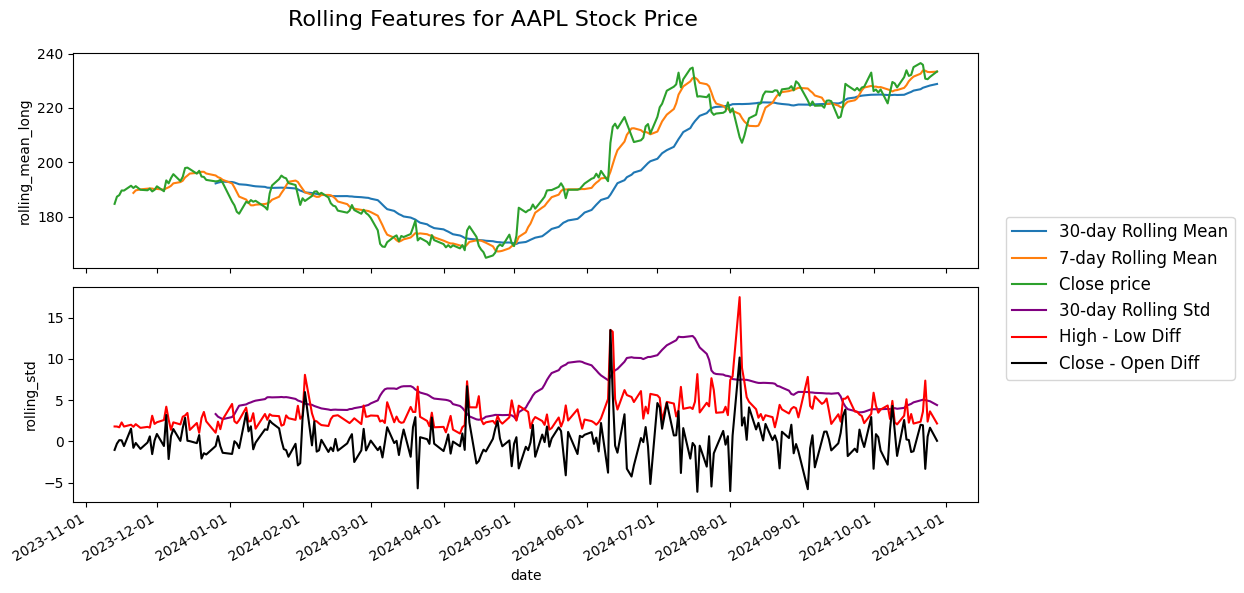

In [26]:
test_ticker =0
test_df = compute_features(price_df, tickers[test_ticker], 30, 7, lags, derivates)
plot_rolling_features(test_df, (10, 6), tickers[test_ticker])

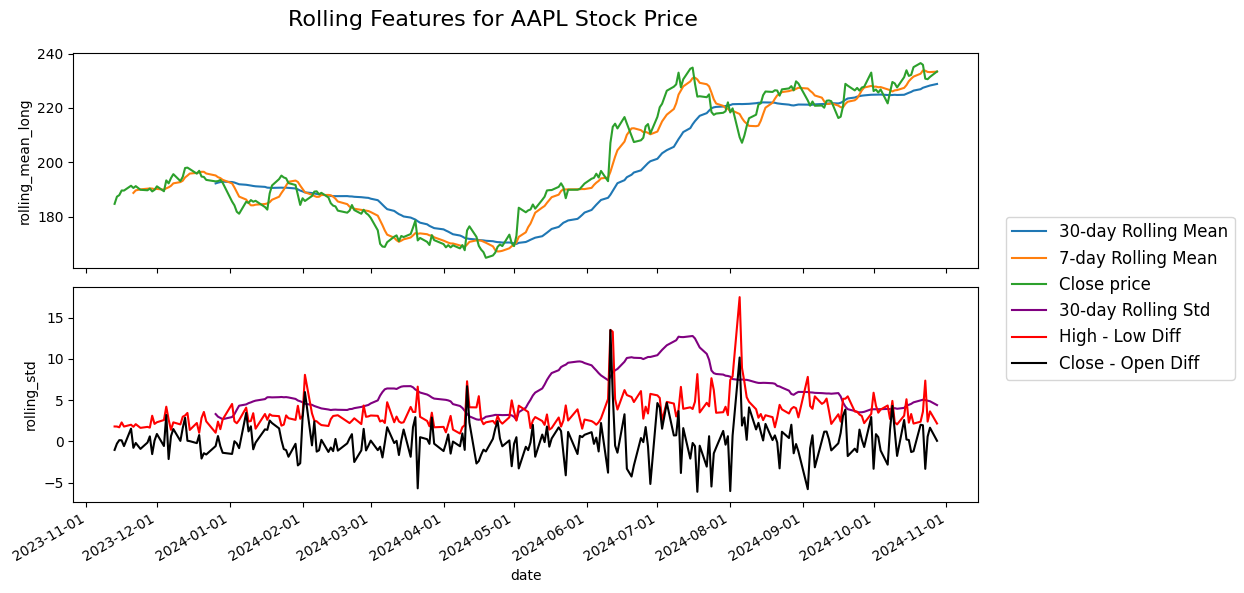

In [27]:
test_ticker =0
test_df = compute_features(price_df, tickers[test_ticker], 30, 7, lags, derivates)
plot_rolling_features(test_df, (10, 6), tickers[test_ticker])

As it can be seen in the autocorrelation and partial autocorrelation plots, the time series exhibits significant autocorrelation at lags 1 and 2, however there is no significant autocorrelation at lag 3 and beyond. This suggests that a simple ARMA model could be appropriate for forecasting. The autocorrelation plot shows that the moving average component is significant until lag 20, therefore using moving average terms up to lag 20 in the model may be beneficial.

In [28]:
test_df = test_df.dropna()  # Drop NaN values resulting from rolling calculations
test_df = test_df.drop(columns=['open', 'high', 'low'])  # Drop open, high, and low columns for modeling
#TODO: feature engineering for volume 
test_df.head()

,date,ticker,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close
29,2023-12-26,AAPL,193.050003,28919300,192.314667,195.222859,3.325447,1.059998,-0.559998,193.600006,194.679993,-0.550003,-1.629990,193.149994
30,2023-12-27,AAPL,193.149994,48087700,192.593000,194.591428,3.009197,2.410004,0.659988,193.050003,193.600006,0.099991,-0.450012,193.580002
31,2023-12-28,AAPL,193.580002,34049900,192.797667,194.261429,2.851297,1.490005,-0.559998,193.149994,193.050003,0.430008,0.529999,192.529999
32,2023-12-29,AAPL,192.529999,42628800,192.948334,193.631428,2.705268,2.669998,-1.369995,193.580002,193.149994,-1.050003,-0.619995,185.639999
33,2024-01-02,AAPL,185.639999,82488700,192.812667,192.318571,2.963040,4.550003,-1.509995,192.529999,193.580002,-6.889999,-7.940002,184.250000


#### Preparing the dataset


In [29]:
## I will create a map for the categorical values this will be used later to handle ticker labels
ticker_map = {v:k for k, v in enumerate(price_df['ticker'].unique())}
ticker_map

{'AAPL': 0, 'GOOGL': 1, 'AMZN': 2, 'TSLA': 3, 'META': 4, 'NVDA': 5, 'MSFT': 6}

In [30]:
# now I will process all tickers to have MA, lagged features, and other relevant features
datasets = []
for ticker in tickers:
    df = compute_features(price_df, ticker, long=30, short=7, lags=lags, derivates=derivates)
    df.dropna(inplace=True)  # Drop NaN values resulting from rolling calculations
    df['ticker_num']= df['ticker'].map(ticker_map)  # Map ticker to numerical value
    datasets.append(df)

In [31]:
# now I have a separate dataset per ticker in the list datasets, the list index matches the ticker dictionary ticker_map
datasets[0]

,date,ticker,open,high,low,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close,ticker_num
29,2023-12-26,AAPL,193.610001,193.889999,192.830002,193.050003,28919300,192.314667,195.222859,3.325447,1.059998,-0.559998,193.600006,194.679993,-0.550003,-1.629990,193.149994,0
30,2023-12-27,AAPL,192.490005,193.500000,191.089996,193.149994,48087700,192.593000,194.591428,3.009197,2.410004,0.659988,193.050003,193.600006,0.099991,-0.450012,193.580002,0
31,2023-12-28,AAPL,194.139999,194.660004,193.169998,193.580002,34049900,192.797667,194.261429,2.851297,1.490005,-0.559998,193.149994,193.050003,0.430008,0.529999,192.529999,0
32,2023-12-29,AAPL,193.899994,194.399994,191.729996,192.529999,42628800,192.948334,193.631428,2.705268,2.669998,-1.369995,193.580002,193.149994,-1.050003,-0.619995,185.639999,0
33,2024-01-02,AAPL,187.149994,188.440002,183.889999,185.639999,82488700,192.812667,192.318571,2.963040,4.550003,-1.509995,192.529999,193.580002,-6.889999,-7.940002,184.250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2024-10-21,AAPL,234.449997,236.850006,234.449997,236.479996,36254500,226.901333,232.587143,4.971251,2.400009,2.029999,235.000000,232.149994,1.479996,4.330002,235.860001,0
236,2024-10-22,AAPL,233.889999,236.220001,232.600006,235.860001,38846600,227.426333,233.774285,5.060168,3.619995,1.970001,236.479996,235.000000,-0.619995,0.860001,230.759995,0
237,2024-10-23,AAPL,234.080002,235.139999,227.759995,230.759995,52287000,227.696333,233.697141,5.012956,7.380005,-3.320007,235.860001,236.479996,-5.100006,-5.720001,230.570007,0
238,2024-10-24,AAPL,229.979996,230.820007,228.410004,230.570007,31109500,227.956333,233.228570,4.950525,2.410004,0.590012,230.759995,235.860001,-0.189987,-5.289993,231.410004,0


#  Training Model

Cross validation is important to tune the hyperparameters of the model and to know if the model is generalizing well to unseen data. However, in time series forecasting, we need to be careful about how we split the data. Traditional cross-validation techniques can lead to data leakage, as they may use future information to predict past values. Therefore, we use techniques like TimeSeriesSplit, which respects the temporal order of the data, therefore a special data splitting strategy is required. For this I am using [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) from sklearn.model_selection.

In [32]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [33]:
from sklearn.preprocessing import OneHotEncoder

# Concatenate datasets and make a copy
tickers.tolist()
df_concat = pd.concat(datasets, axis=0)
df_preprocessed = df_concat.copy()

# ######## One-hot encode the 'ticker' column ########
# encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoded = encoder.fit_transform(df_preprocessed[['ticker']])  # note the double brackets

# one_hot_df = pd.DataFrame(
#     one_hot_encoded,
#     columns=encoder.get_feature_names_out(['ticker']),
#     index=df_preprocessed.index)
# df_encoded = pd.concat([df_preprocessed, one_hot_df], axis=1).drop('ticker', axis=1)

df_encoded = df_concat
df_encoded.head()


,date,ticker,open,high,low,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close,ticker_num
29,2023-12-26,AAPL,193.610001,193.889999,192.830002,193.050003,28919300,192.314667,195.222859,3.325447,1.059998,-0.559998,193.600006,194.679993,-0.550003,-1.629990,193.149994,0
30,2023-12-27,AAPL,192.490005,193.500000,191.089996,193.149994,48087700,192.593000,194.591428,3.009197,2.410004,0.659988,193.050003,193.600006,0.099991,-0.450012,193.580002,0
31,2023-12-28,AAPL,194.139999,194.660004,193.169998,193.580002,34049900,192.797667,194.261429,2.851297,1.490005,-0.559998,193.149994,193.050003,0.430008,0.529999,192.529999,0
32,2023-12-29,AAPL,193.899994,194.399994,191.729996,192.529999,42628800,192.948334,193.631428,2.705268,2.669998,-1.369995,193.580002,193.149994,-1.050003,-0.619995,185.639999,0
33,2024-01-02,AAPL,187.149994,188.440002,183.889999,185.639999,82488700,192.812667,192.318571,2.963040,4.550003,-1.509995,192.529999,193.580002,-6.889999,-7.940002,184.250000,0


In [34]:
df_encoded.shape

(1477, 18)

In [35]:

# Setting up the TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# these are lists that will store the training and test sets of each split
X_train, X_test, y_train, y_test = [], [], [], []

# Saving a copy of the preprocessed DataFrame to not alter the original data
df_preprocessed = df_encoded.copy()

#Getting rid of unnecessary columns (this can be modified)
df_preprocessed.drop(columns=['open','high','low'], inplace=True)

# Making sure date is in datetime format and sorted
df_preprocessed['date'] = pd.to_datetime(df_preprocessed['date'])
df_preprocessed.sort_values(by=['date','ticker_num'], inplace=True)
#df_preprocessed.drop(columns=['ticker_num'], inplace=True) # Uncomment this only if one hot encoding is used 

"by this point the dataset is sorted by date and ticker_num and matching X and y"
# # Drop date columns for modeling
df_preprocessed.drop(columns=['date'], inplace=True)  
# getting the target variable
y = df_preprocessed['target_close']
# Drop target and unused columns
X_data = df_preprocessed.drop(columns=['target_close'])  
# Ensuring only numerical features are used and splitting the data
X_data = X_data.select_dtypes(include=[np.number])


for train_index, test_index in tscv.split(df_concat):
    X_train.append(X_data.iloc[train_index])
    X_test.append(X_data.iloc[test_index])
    y_train.append(y.iloc[train_index])
    y_test.append(y.iloc[test_index])
    
print(f"Number of splits: {n_splits}")
print(f"Number of training sets: {len(X_train)}")
print(f"Number of test sets: {len(X_test)}")


Number of splits: 3
Number of training sets: 3
Number of test sets: 3


In [36]:
df_preprocessed.head()

,ticker,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close,ticker_num
29,AAPL,193.050003,28919300,192.314667,195.222859,3.325447,1.059998,-0.559998,193.600006,194.679993,-0.550003,-1.629990,193.149994,0
270,GOOGL,141.520004,16780300,135.110001,138.117144,3.180270,1.489990,-0.069992,141.490005,140.419998,0.029999,1.100006,140.369995,1
511,AMZN,153.410004,25067200,147.602333,152.945714,3.392431,0.949997,-0.149994,153.419998,153.839996,-0.009995,-0.429993,153.339996,2
752,TSLA,256.609985,86892400,242.166333,253.369997,8.010705,5.059998,2.119980,252.539993,254.500000,4.069992,2.109985,261.440002,3
993,META,354.829987,9898600,335.532334,348.784284,10.029817,3.529999,-0.160004,353.390015,354.089996,1.439972,0.739990,357.829987,4


In [37]:
X_train[0]

,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,ticker_num
29,193.050003,28919300,192.314667,195.222859,3.325447,1.059998,-0.559998,193.600006,194.679993,-0.550003,-1.629990,0
270,141.520004,16780300,135.110001,138.117144,3.180270,1.489990,-0.069992,141.490005,140.419998,0.029999,1.100006,1
511,153.410004,25067200,147.602333,152.945714,3.392431,0.949997,-0.149994,153.419998,153.839996,-0.009995,-0.429993,2
752,256.609985,86892400,242.166333,253.369997,8.010705,5.059998,2.119980,252.539993,254.500000,4.069992,2.109985,3
993,354.829987,9898600,335.532334,348.784284,10.029817,3.529999,-0.160004,353.390015,354.089996,1.439972,0.739990,4
...,...,...,...,...,...,...,...,...,...,...,...,...
322,138.500000,27563400,140.958669,134.768572,4.973461,2.350006,1.470001,137.669998,135.410004,0.830002,3.089996,1
563,175.389999,36610600,171.240666,174.961430,5.416695,4.779999,1.889999,171.960007,175.350006,3.429993,0.039993,2
804,177.539993,87391700,189.736666,179.245712,8.364197,7.019989,-0.230011,177.770004,175.339996,-0.230011,2.199997,3
1045,499.750000,15448200,472.753665,497.997144,29.916794,17.579987,6.489990,483.589996,505.950012,16.160004,-6.200012,4


In [38]:
#### This is to get the tickers with a hot encoding
# aux = X_test[0]
# tk = 0
# index_ticker = aux[aux[f'ticker_{tickers[tk]}'] == 1].index
# y_test_index = [y.iloc[i] for i in index_ticker]
# y_test_index

## Model Training and Evaluation

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Define XGBRegressor, in this case I will use a GPU-accelerated version of XGBoost for faster training, as I have an available GPU.
# I will also use the histogram-based algorithm for faster training on large datasets.
xgb_model = xgb.XGBRegressor(
    tree_method="hist", 
    device="cuda",
    random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 170],  # Number of trees
    'max_depth': [5, 7, 9],  # Maximum depth of a tree
    'learning_rate': [0.2, 0.3],  # Step size shrinkage
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition
    }

# GridSearchCV (e.g., with TimeSeriesSplit stored in `tscv`)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)


def Train_and_test(X_train, y_train, X_test, y_test, k_fold, grid_search, ticker):
    """This function trains the model and tests it on the test set."""
    X_test[k_fold].reset_index(drop=True, inplace=True)
    y_test[k_fold].reset_index(drop=True, inplace=True)
    
    # Fit the model 
    grid_search.fit(X_train[k_fold], y_train[k_fold])  # Use DataFrame directly
    # saving a copy form the test data to get the indexes. (tickers) 
    aux = X_test[k_fold].copy()
    # Best model & prediction
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test[k_fold])

    # Evaluation using MSE and R-squared
    mse = mean_squared_error(y_test[k_fold], y_pred)
    r2 = r2_score(y_test[k_fold], y_pred)
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    # Plot
    # # Uncomment this for one hot encoding
    # index_ticker = aux[aux[f'ticker_{tickers[ticker]}'] == 1].index
    index_ticker = aux[aux['ticker_num'] == ticker].index
    y = y_test[k_fold].copy()
    
    y_test_index = [y.iloc[i] for i in index_ticker]
    y_pred_index = y_pred.copy()
    y_pred_index = [y_pred_index[i] for i in index_ticker]

    plt.figure(figsize=(8, 6))  
    plt.plot(y_test_index, label='True data', color='blue')
    plt.plot(y_pred_index, label='Predicted data', color='red', alpha=0.7)
    plt.title(f'XGBoost Predictions vs Actual Values for Ticker {tickers[ticker]}')
    plt.legend(title='Data', bbox_to_anchor=(1.1, 1), loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Power Consumption (MW)')
    plt.xticks(rotation=45)
    plt.show()
    
    return best_model, y_pred, grid_search.best_params_

Training and testing for split 1 with ticker as demo TSLA:


c:\Users\hecma\anaconda3\envs\ML_projects\Lib\site-packages\xgboost\core.py:729: UserWarning:

[17:30:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 170}
Root Mean Squared Error: 11.90494853816362
R-squared: 0.9924800091732742


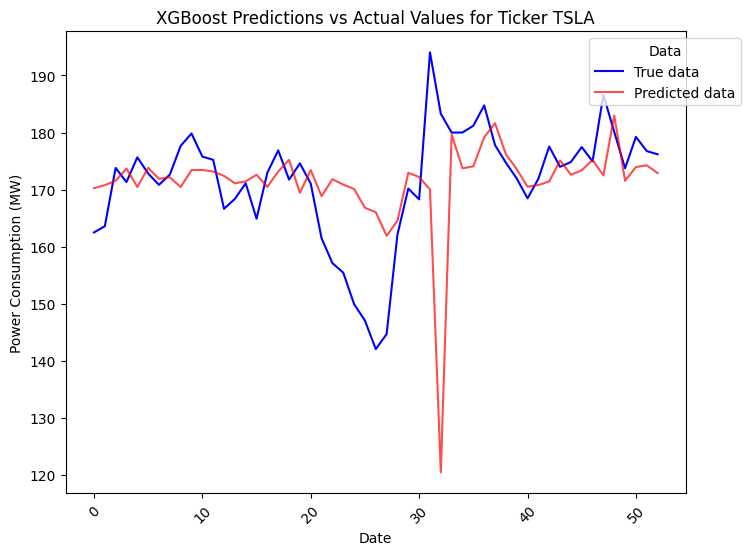

Best parameters for split 1: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 170}

Training and testing for split 2 with ticker as demo TSLA:
Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 170}
Root Mean Squared Error: 12.174895846578014
R-squared: 0.9917323952088919


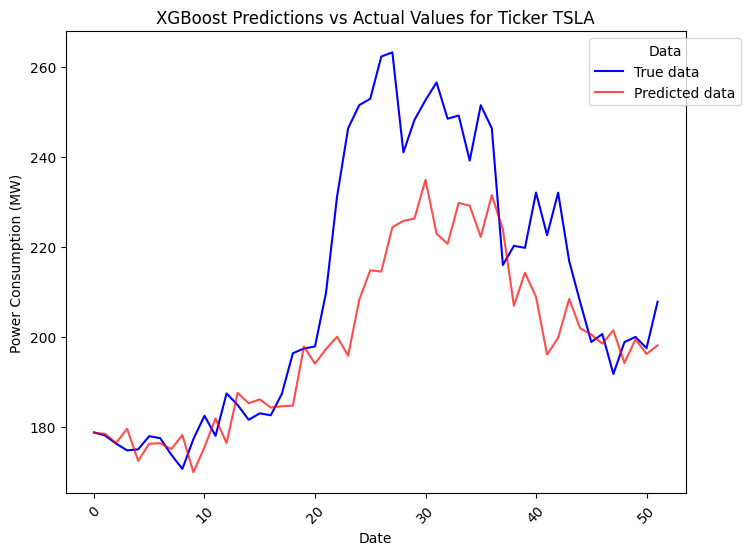

Best parameters for split 2: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 170}

Training and testing for split 3 with ticker as demo TSLA:
Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Root Mean Squared Error: 22.353890734174175
R-squared: 0.9762627337288913


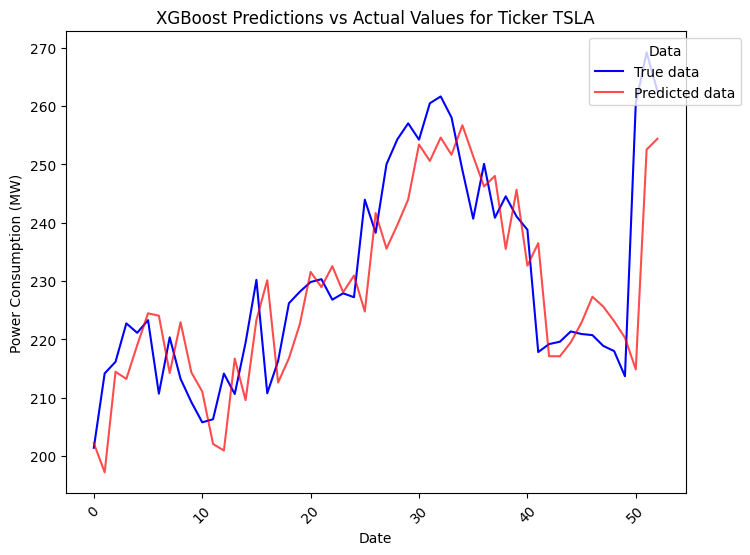

Best parameters for split 3: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}



In [40]:
ticker = 3
for n in range(n_splits):
    print(f"Training and testing for split {n+1} with ticker as demo {tickers[ticker]}:")
    best_model, y_pred, best_params = Train_and_test(X_train, y_train, X_test, y_test, n, grid_search, ticker)
    print(f"Best parameters for split {n+1}: {best_params}\n")

Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 170}
Root Mean Squared Error: 22.065706093410622
R-squared: 0.9768708265789795


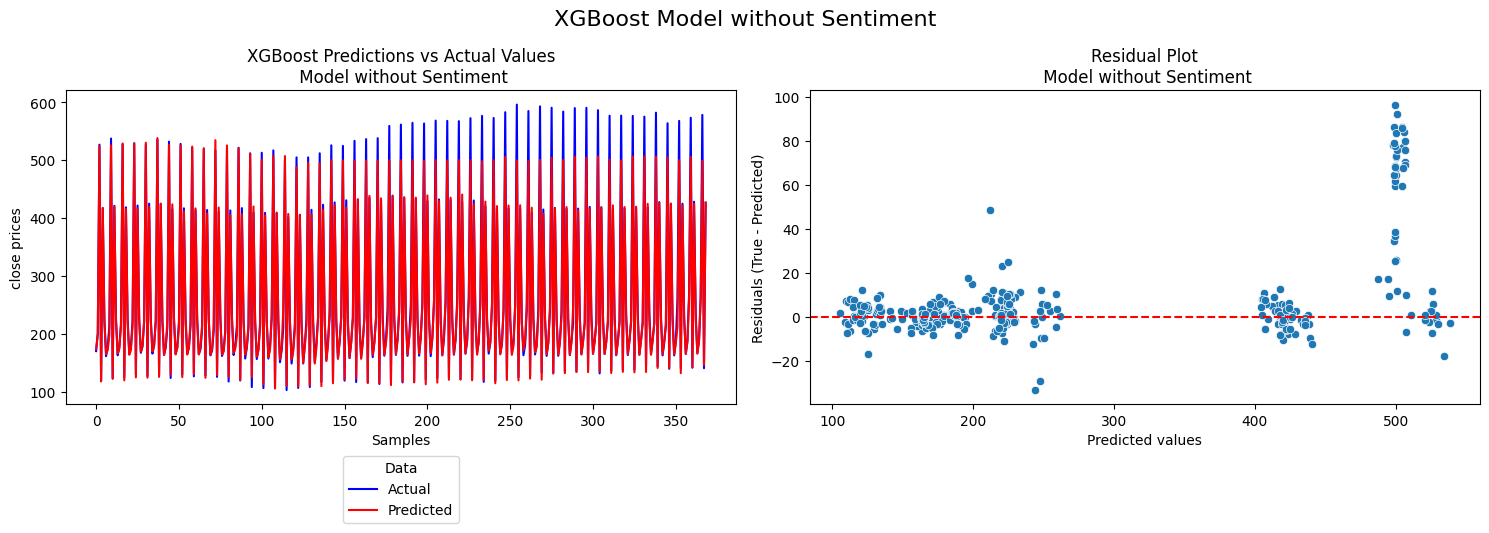

In [41]:
best_params =  {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 170}

xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    tree_method="hist",
    device="cuda")
i = n_splits - 1
# Fit the model on the entire training set
xgb_model.fit(X_train[i], y_train[i])
# Make predictions on the test set
y_pred = xgb_model.predict(X_test[i])
# Evaluate the model
mse = mean_squared_error(y_test[i], y_pred)
r2 = r2_score(y_test[i], y_pred)
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(y_test[i].values, label='Actual', color='blue')
axs[0].plot(y_pred, label='Predicted', color='red')
axs[0].set_title('XGBoost Predictions vs Actual Values\n Model without Sentiment')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('close prices')
axs[0].legend(title='Data', bbox_to_anchor=(0.5,-0.4), loc='lower center')
residuals = y_test[i] - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=axs[1])
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_xlabel("Predicted values")
axs[1].set_ylabel("Residuals (True - Predicted)")
axs[1].set_title("Residual Plot\n Model without Sentiment")

fig.suptitle("XGBoost Model without Sentiment", fontsize=16)
fig.tight_layout()

In [42]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import InferenceClient
import os

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
# os.environ['HF_TOKEN'] = 'hugging face token'

In [43]:
text = news_df['summary'][rand_int]


In [45]:
import torch
text = news_df['summary'][rand_int]

label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
def get_result(text):
    with torch.no_grad():
        input = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        result = model(**input)
    return result

result = get_result(text)
print(result)

predicted_class = result[0].argmax().item()
confidence = result[0].max().item()
print(f"Sentiment: {label_map[predicted_class]}, Score: {confidence:.4f}")

SequenceClassifierOutput(loss=None, logits=tensor([[-1.4605,  2.6788, -1.0215]]), hidden_states=None, attentions=None)
Sentiment: neutral, Score: 2.6788


In [46]:
result = get_result(text)
result.logits.detach().numpy()

array([[-1.4605393,  2.678798 , -1.021546 ]], dtype=float32)

In [47]:
def get_sentiment_scores(text):
    """
    Returns a dict with the sentiment scores of the text using FinBERT.
    Output keys: 'positive', 'negative', 'neutral'
    """
    result = get_result(text).logits.numpy()
    # Convert the list of LabelScore outputs into a dict
    scores = {label_map[k]:result[0][k] for k, v in enumerate(result[0])}

    return scores
get_sentiment_scores(news_df['summary'][rand_int])

{'negative': np.float32(-1.4605393),
 'neutral': np.float32(2.678798),
 'positive': np.float32(-1.021546)}

In [48]:
scores = news_df[0:5].summary.apply(get_sentiment_scores).apply(pd.Series)
scores

,negative,neutral,positive
0,-0.359966,0.331241,0.047004
1,-1.482341,1.428764,0.431565
2,0.098329,-2.164948,2.230287
3,0.124815,-2.177658,2.168080
4,1.243282,-2.601956,1.187728


Now I have a way to get the sentiment scores for each article in the DataFrame. I will first try to get sentiments without preprocessing the text as Finbert expects raw text input.
First I will merge all news from a single day in each article's summary to get a general sentiment input per entry.

In [49]:
news_df_processed = news_df.copy()
news_df_processed['date'] = pd.to_datetime(news_df_processed['datetime']).dt.date
df_encoded['date'] = pd.to_datetime(df_encoded['date']).dt.date
news_df_processed.drop(columns=['datetime', 'headline'], inplace=True)
scores = news_df_processed.summary.apply(get_sentiment_scores).apply(pd.Series)
df_merged = pd.concat([news_df_processed, scores], axis=1)
df_merged.head(2)
# news_df_processed = news_df_processed.groupby(['date', 'ticker']).agg({'summary': ' '.join}).reset_index()
# tensors in finbert only support up to 512 characters, as some news are redundant I will truncate them
# news_df_processed['summary'] = news_df_processed.summary.str.slice(0,512)
# news_df_processed.head(2)

,ticker,summary,date,negative,neutral,positive
0,AAPL,-- Apple overhauled the design of its Mac mini...,2024-10-29,-0.359966,0.331241,0.047004
1,AAPL,TECH giant Apple will not be allowed to sell i...,2024-10-29,-1.482341,1.428764,0.431565


In [50]:
df_bert = df_merged.groupby(['date', 'ticker']).agg({'positive':'mean', 'negative':'mean', 'neutral':'mean'}).reset_index()
df_bert.head(5)

,date,ticker,positive,negative,neutral
0,2023-11-13,AAPL,0.125295,-1.863161,2.545623
1,2023-11-13,AMZN,0.503878,-0.618015,0.270289
2,2023-11-13,MSFT,2.107638,0.440333,-2.454361
3,2023-11-13,TSLA,-0.434983,0.882155,-1.021109
4,2023-11-14,AAPL,-1.668399,2.037575,-1.532535


In [51]:
# I performed an inner join, as nan values in either text or numerical values wouldnt be possible to handle.
df_merged = df_bert.merge(df_encoded, on=['date', 'ticker'], how='inner')
df_merged.head(2)

,date,ticker,positive,negative,neutral,open,high,low,close,volume,...,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close,ticker_num
0,2023-12-26,AMZN,2.252308,-0.780321,-1.097961,153.559998,153.979996,153.029999,153.410004,25067200,...,152.945714,3.392431,0.949997,-0.149994,153.419998,153.839996,-0.009995,-0.429993,153.339996,2
1,2023-12-26,NVDA,2.016640,0.263453,-2.214477,48.967999,49.599998,48.959999,49.278999,244200000,...,49.111572,1.305419,0.639999,0.311001,48.830002,48.990002,0.448997,0.288998,49.417000,5


In [52]:
df_merged.isna().sum()

date                  0
ticker                0
positive              0
negative              0
neutral               0
open                  0
high                  0
low                   0
close                 0
volume                0
rolling_mean_long     0
rolling_mean_short    0
rolling_std           0
high_low_diff         0
close_open_diff       0
lag_1                 0
lag_2                 0
1_diff                0
2_diff                0
target_close          0
ticker_num            0
dtype: int64

In [53]:
df_merged.to_csv("../data/sentiment_prices.csv", index=False)

Now I have a dataset with sentiment scores and stock prices, which I can use for further analysis and modeling. I will repeat the preprocessing and training steps for the new dataset and compare the results with the previous one.

In [55]:
# Setting up the TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
# these are lists that will store the training and test sets of each split
X_train, X_test, y_train, y_test = [], [], [], []

df_preprocessed = df_merged.copy()
#Getting rid of unnecessary columns (this can be modified)
df_preprocessed.drop(columns=['open','high','low'], inplace=True)
# df_preprocessed.drop(columns=['ticker'], inplace=True)  # Drop ticker column for modeling
# Making sure date is in datetime format and sorted
df_preprocessed['date'] = pd.to_datetime(df_preprocessed['date'])
df_preprocessed.sort_values(by=['date','ticker_num'], inplace=True)
#df_preprocessed.drop(columns=['ticker_num'], inplace=True)
#df_preprocessed.sort_index(inplace=True)
"by this point the dataset is sorted by date and ticker_num and matching X and y"
# # Drop date columns for modeling
df_preprocessed.drop(columns=['date'], inplace=True)  
# getting the target variable
y = df_preprocessed['target_close']
X_data = df_preprocessed.drop(columns=['target_close'])  # Drop target and lagged features
# Ensuring only numerical features are used and splitting the data
X_data = X_data.select_dtypes(include=[np.number])


for train_index, test_index in tscv.split(df_preprocessed):
    X_train.append(X_data.iloc[train_index])
    X_test.append(X_data.iloc[test_index])
    y_train.append(y.iloc[train_index])
    y_test.append(y.iloc[test_index])
    
print(f"Number of splits: {n_splits}")
print(f"Number of training sets: {len(X_train)}")
print(f"Number of test sets: {len(X_test)}")

df_preprocessed.head()

Number of splits: 3
Number of training sets: 3
Number of test sets: 3


,ticker,positive,negative,neutral,close,volume,rolling_mean_long,rolling_mean_short,rolling_std,high_low_diff,close_open_diff,lag_1,lag_2,1_diff,2_diff,target_close,ticker_num
0,AMZN,2.252308,-0.780321,-1.097961,153.410004,25067200,147.602333,152.945714,3.392431,0.949997,-0.149994,153.419998,153.839996,-0.009995,-0.429993,153.339996,2
1,NVDA,2.016640,0.263453,-2.214477,49.278999,244200000,48.223633,49.111572,1.305419,0.639999,0.311001,48.830002,48.990002,0.448997,0.288998,49.417000,5
2,AAPL,0.300518,-0.240287,0.074915,193.149994,48087700,192.593000,194.591428,3.009197,2.410004,0.659988,193.050003,193.600006,0.099991,-0.450012,193.580002,0
3,AMZN,1.134874,0.500571,-1.875108,153.339996,31434700,147.960666,153.427141,3.412423,1.660004,-0.220001,153.410004,153.419998,-0.070007,-0.080002,153.380005,2
7,TSLA,-1.039480,0.764640,-0.383461,261.440002,106494400,243.424000,254.504283,7.974868,5.820007,3.089996,256.609985,252.539993,4.830017,8.900009,253.179993,3


Training and testing for split 1 with ticker as demo TSLA:
Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 170}
Root Mean Squared Error: 8.703894796255712
R-squared: 0.9957182041134605


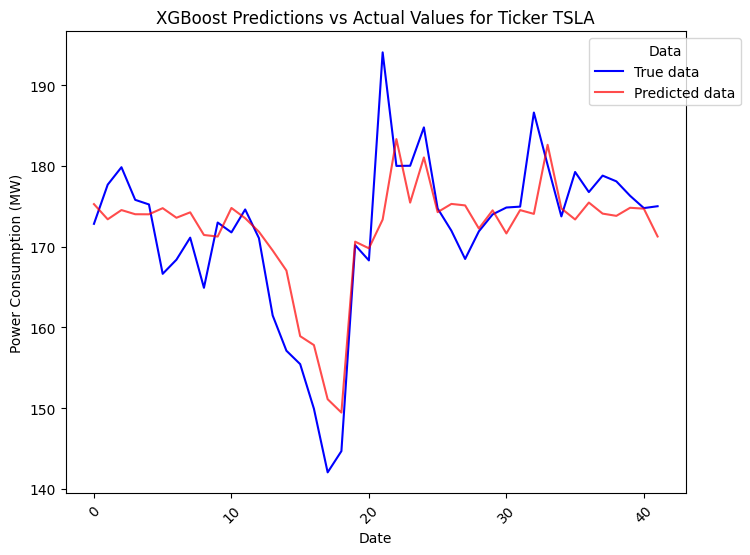

Best parameters for split 1: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 170}

Training and testing for split 2 with ticker as demo TSLA:
Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
Root Mean Squared Error: 13.327115330526043
R-squared: 0.9904693439439796


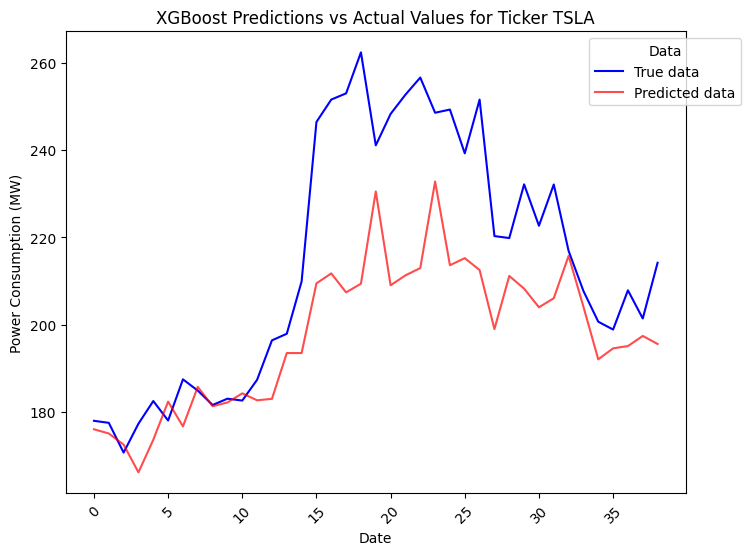

Best parameters for split 2: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}

Training and testing for split 3 with ticker as demo TSLA:
Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Root Mean Squared Error: 19.177095071839297
R-squared: 0.9825684759061182


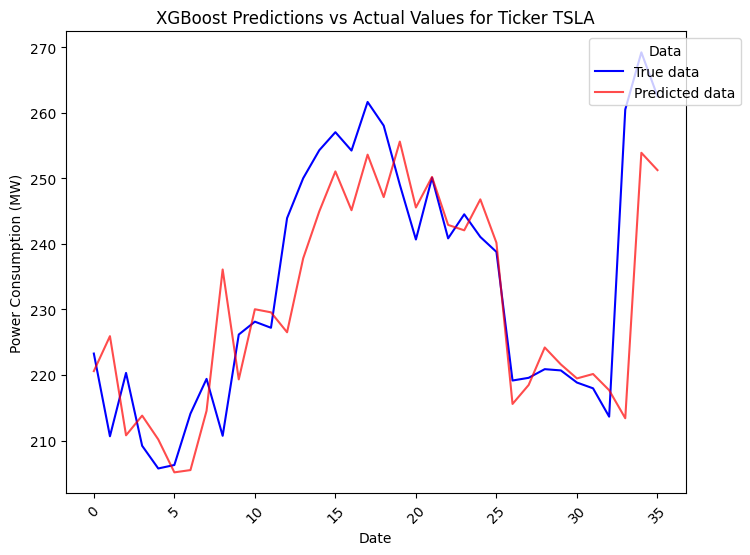

Best parameters for split 3: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}



In [56]:
ticker = 3
for n in range(n_splits):
    print(f"Training and testing for split {n+1} with ticker as demo {tickers[ticker]}:")
    best_model, y_pred, best_params = Train_and_test(X_train, y_train, X_test, y_test, n, grid_search, ticker)
    print(f"Best parameters for split {n+1}: {best_params}\n")

Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Root Mean Squared Error: 19.177095071839297
R-squared: 0.9825684759061182


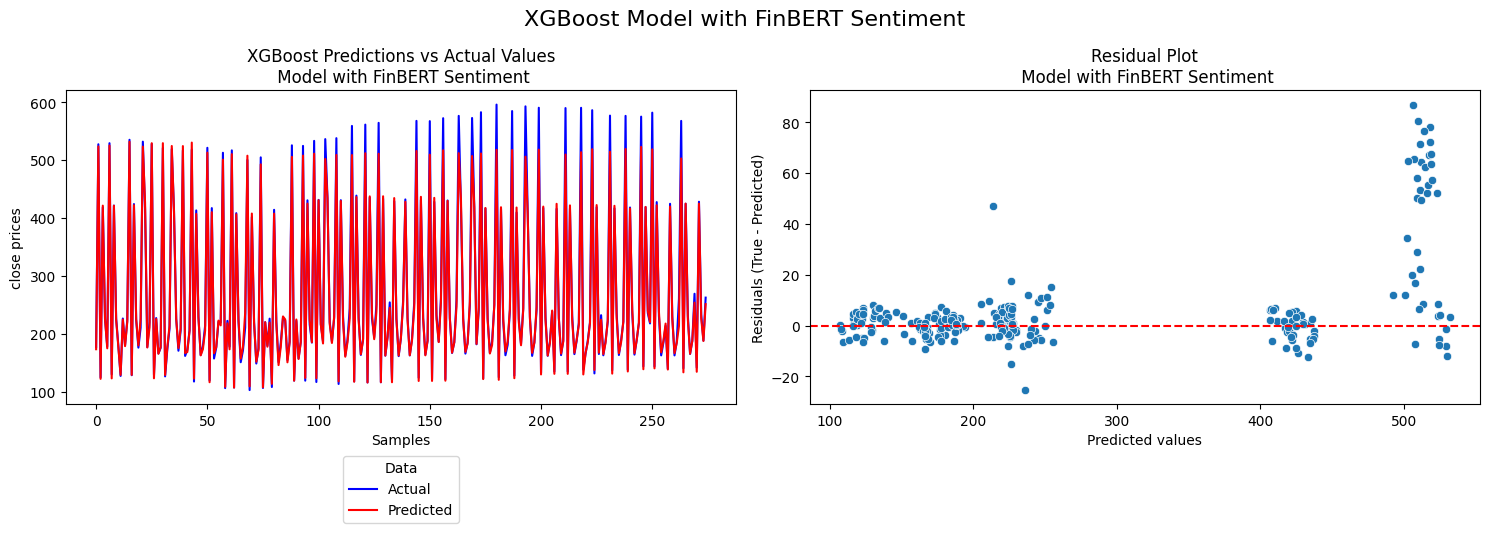

In [58]:
best_params =  {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}

xgb_model_sentiment = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    tree_method="hist",
    device="cuda")
i = n_splits - 1
# Fit the model on the entire training set
xgb_model_sentiment.fit(X_train[i], y_train[i])
# Make predictions on the test set
y_pred = xgb_model_sentiment.predict(X_test[i])
# Evaluate the model
mse = mean_squared_error(y_test[i], y_pred)
r2 = r2_score(y_test[i], y_pred)
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(y_test[i].values, label='Actual', color='blue')
axs[0].plot(y_pred, label='Predicted', color='red')
axs[0].set_title('XGBoost Predictions vs Actual Values\n Model with FinBERT Sentiment')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('close prices')
axs[0].legend(title='Data', bbox_to_anchor=(0.5,-0.4), loc='lower center')
residuals = y_test[i] - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=axs[1])
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_xlabel("Predicted values")
axs[1].set_ylabel("Residuals (True - Predicted)")
axs[1].set_title("Residual Plot\n Model with FinBERT Sentiment")

fig.suptitle("XGBoost Model with FinBERT Sentiment", fontsize=16)
fig.tight_layout()

# Result Discussion 

| Model Description                 | Hyperparameters (best)                                                      | RMSE      | R²         |
| --------------------------------- | --------------------------------------------------------------------------- | --------- | ---------- |
| **Baseline Model (no sentiment)** | `{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 170}` | 22.00 | 0.9769     |
| **Model + FinBERT Sentiment**     | `{'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}`   | **19.177** | **0.9825** |

Adding the sentiment features from FinBERT slightly improved the model:

RMSE decreased from 22.01 → 19.177 (≈0.8% improvement)

R² increased from 0.9770 → 0.9825
→ small but consistent improvement in predictive accuracy

- This suggests that news sentiment provides additional explanatory power beyond historical price features alone.
- Even if the improvement that the metrics show is modest, it is still a valuable enhancement to the model's performance, some observations from the graphs are:
    - The residuals for the model with FinBERT sentiment appear to be closer to zero, and with less variance compared to the baseline model, except for high volatility periods.
    - The predictions from the model with FinBERT sentiment are closer to the actual values, particularly during periods of high volatility.
    - The model using sentiment analysis manages to capture sudden market movements better than the baseline model.

**Suggestions for Further Improvement:**
1. Hyperparameter Tuning:  Further tuning of hyperparameters of the XGBoost model could lead to better performance. Techniques such as Grid Search or Random Search can be employed to find optimal values for parameters like `max_depth`, `learning_rate`, and `n_estimators`.
2. Feature Engineering:  Explore additional features that could enhance model performance. This may include:
   - Incorporating more advanced sentiment analysis techniques or additional NLP features.
   - Adjusting the windows size for historical data to perform other rolling window calculations (e.g., rolling averages, rolling volatility).
   - Exploring other machine learning models or ensemble methods to improve predictions, such as neural networks.
   - Feature importance and selection techniques can be applied to identify the most impactful features and potentially reduce dimensionality.


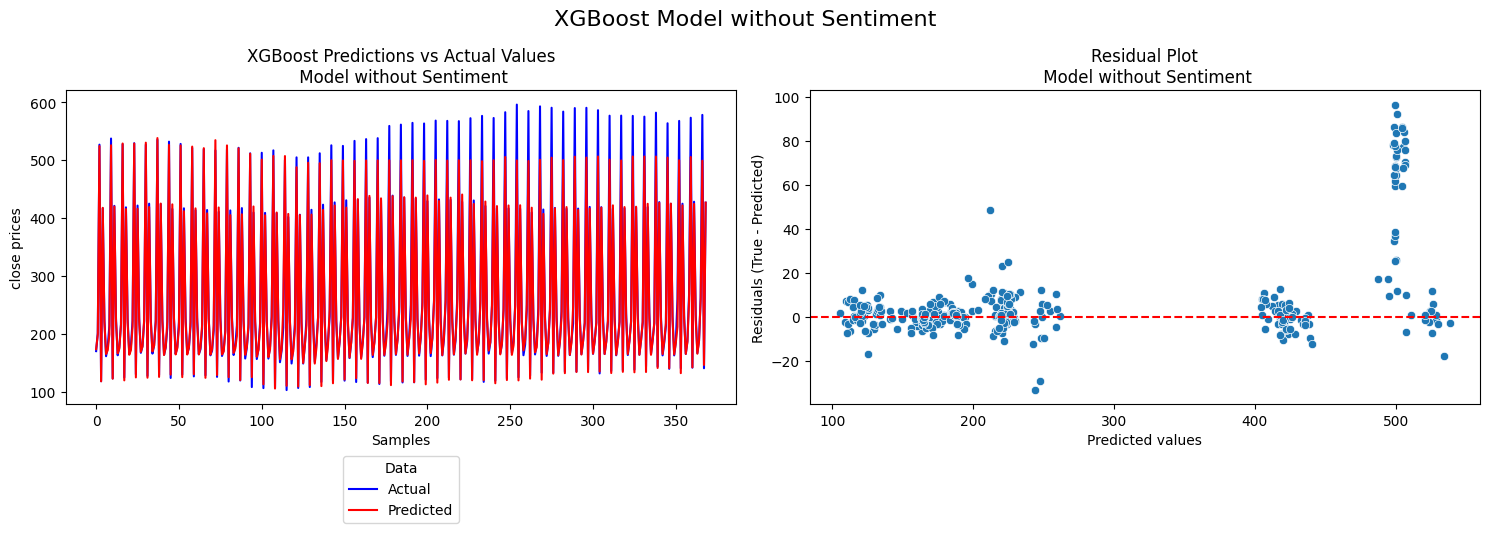
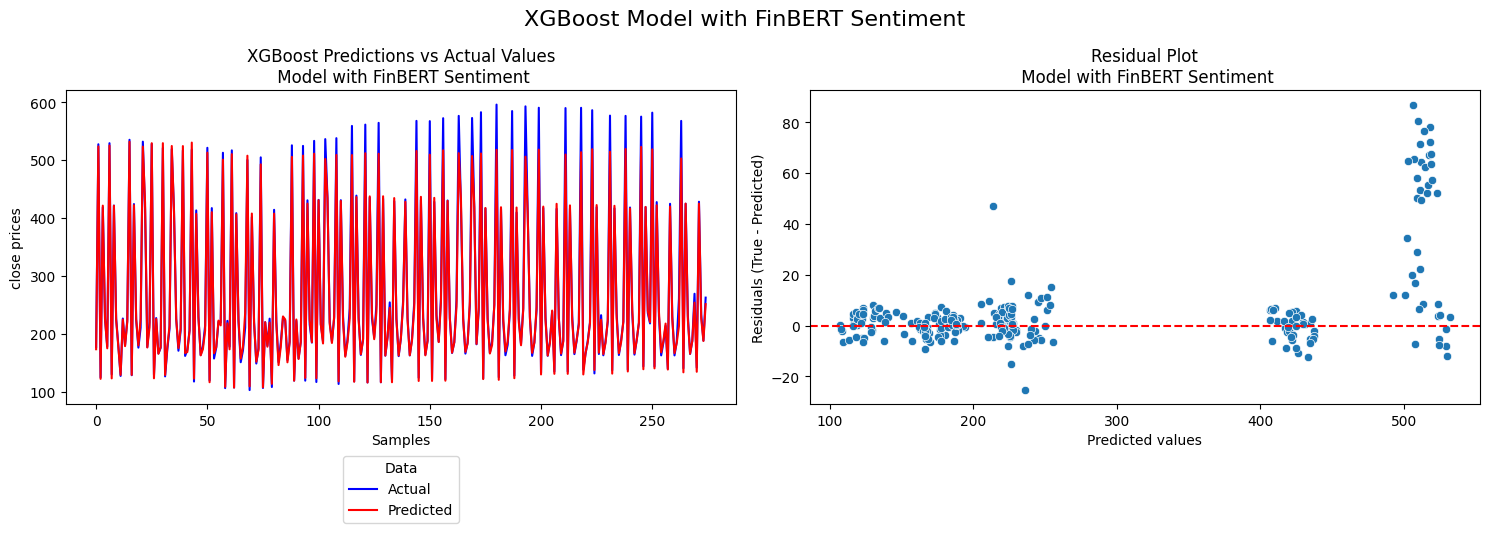

In [59]:
print(f"the size of the dataset with sentiment is: {df_merged.shape}")
print(f"the size of the dataset without sentiment is: {df_encoded.shape}")
print(f"the difference in size is: {( df_encoded.shape[0]-df_merged.shape[0])/df_encoded.shape[0]*100:.2f}% fewer samples when using sentiment")

the size of the dataset with sentiment is: (1103, 21)
the size of the dataset without sentiment is: (1477, 18)
the difference in size is: 25.32% fewer samples when using sentiment


### Takeaways: 
- The size of the dataset with sentiment is smaller in datapoints, this is because some dates didnt have news and I decided to drop those rows, to avoid introducing noise into the model.
Despite this, the model with sentiment may still capture important information from the news articles, potentially leading to better predictions, considering that the amount of datapoints is 25% smaller. This shows to be very promissing, considering that there is some loss in the computation of rolling features and the amount of news. 
- **Summary of the pipeline**
    - Data Collection: Gather historical stock prices and news articles.
    - Data Preprocessing: Clean and preprocess the data, including sentiment analysis on news articles.
    - Feature Engineering: Create rolling features and incorporate sentiment scores.
        - Rolling statistics using the ACF and PACF plots to make lag features and Moving Averages.
        - Engineer features based on reference papers.
        - **With Sentiment analysis** Use FinBERT embeddings as additional features.
    - Model Training: Train the XGBoost model with and without sentiment features.
    - Evaluation: Compare model performance using metrics like RMSE and R-squared.

##### Notes: 
- I tried to set the categories as one hot encoded variables and ordinal variables for the machine learning model. both approaches work, to reduce the dimensionality of the data I will use ordinal encoding.
- All features were considered at a first stage, however unprocessed features were removed in the final model, as they did not improve the model performance and are a linear combination of the processed features.


#### References
[1] “XGBoost for stock trend & prices prediction.” Accessed: Aug. 16, 2025. [Online]. Available: https://kaggle.com/code/mtszkw/xgboost-for-stock-trend-prices-prediction

[2] A. Kis, “Understanding Autocorrelation and Partial Autocorrelation Functions (ACF and PACF),” Medium. Accessed: Aug. 16, 2025. [Online]. Available: https://medium.com/@kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5

[3] “Stock signals | US stocks indicator & average | Fidelity.” Accessed: Aug. 16, 2025. [Online]. Available: https://www.fidelity.com/viewpoints/active-investor/moving-averages

[4] M. Vijh, D. Chandola, V. A. Tikkiwal, and A. Kumar, “Stock Closing Price Prediction using Machine Learning Techniques,” Procedia Computer Science, vol. 167, pp. 599–606, 2020, doi: 10.1016/j.procs.2020.03.326.

[5] “Stock Analysis,” Corporate Finance Institute. Accessed: Aug. 16, 2025. [Online]. Available: https://corporatefinanceinstitute.com/resources/career-map/sell-side/capital-markets/stock-analysis/

[6] “ProsusAI/finbert · Hugging Face.” Accessed: Aug. 16, 2025. [Online]. Available: https://huggingface.co/ProsusAI/finbert

[7] “(PDF) Regression Analysis with Categorical Variables,” ResearchGate. Accessed: Aug. 16, 2025. [Online]. Available: https://www.researchgate.net/publication/348421623_Regression_Analysis_with_Categorical_Variables

[8] Q. Zhang, Y. Zhang, F. Bao, Y. Liu, C. Zhang, and P. Liu, “Incorporating stock prices and text for stock movement prediction based on information fusion,” Engineering Applications of Artificial Intelligence, vol. 127, p. 107377, Jan. 2024, doi: 10.1016/j.engappai.2023.107377.

[9] “Coding Systems for Categorical Variables in Regression Analysis.” Accessed: Aug. 15, 2025. [Online]. Available: https://stats.oarc.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis/

[10] D. K. Hannay, Chapter 12 Regression with Categorical Variables | Introduction to Statistics and Data Science. Accessed: Aug. 15, 2025. [Online]. Available: https://faculty.nps.edu/rbassett/_book/regression-with-categorical-variables.html

[11] R. U. G, N. D, A. G. Devali, and R. Vastrad, “Analysis of Text Data For Stock Prediction,” IJRASET, vol. 10, no. 5, pp. 3391–3395, May 2022, doi: 10.22214/ijraset.2022.43132.

[12] “4 Ways to Predict Market Performance,” Investopedia. Accessed: Aug. 16, 2025. [Online]. Available: https://www.investopedia.com/articles/07/mean_reversion_martingale.asp
